In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
#create Spark session
spark = SparkSession.builder.appName('reddit').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
#spark.sparkContext.getConf().getAll()

In [4]:
!hdfs dfs -ls -R /user/caixinya/data

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
-rw-r--r--   3 caixinya caixinya 4996487914 2021-11-17 11:07 /user/caixinya/data/Reddit_5G.csv
-rw-r--r--   3 caixinya caixinya 1406097363 2021-11-30 19:05 /user/caixinya/data/Reddit_data_cleaned.csv
drwxr-xr-x   - caixinya caixinya          0 2021-11-13 15:16 /user/caixinya/data/airport
-rw-r--r--   3 caixinya caixinya    8905734 2021-11-13 15:16 /user/caixinya/data/airport/airports.json
-rw-r--r--   3 caixinya caixinya     968006 2021-11-13 15:16 /user/caixinya/data/airport/airports1.json
-rw-r--r--   3 caixinya caixinya    9719582 2021-11-13 15:16 /user/caixinya/data/airport/flights.csv
-rw-r--r--   3 caixinya caixinya       1254 2021-11-11 09:22 /user/caixinya/data/chicago_community.csv
drwxr-xr-x   - caixinya caixinya          0 2021-11-12 11:56 /user/caixinya/data/covid_table
-rwxr-xr-x   3 caixinya caixinya      95729 2021-11-12 11:49 /user/caixinya/data/covid_table/covid.csv


In [5]:
!hdfs dfs -du  /user/caixinya/data/Reddit_5G.csv

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
4996487914  14989463742  /user/caixinya/data/Reddit_5G.csv


## 1. Import Data

In [6]:
df = spark.read \
    .option("delimiter",",") \
    .option("multiLine","true") \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("/user/caixinya/data/Reddit_data_cleaned.csv",inferSchema=True, header=True)

In [7]:
df.printSchema()

root
 |-- body: string (nullable = true)
 |-- clean_comment: string (nullable = true)
 |-- category: integer (nullable = true)



In [8]:
df.show(10)

+--------------------+--------------------+--------+
|                body|       clean_comment|category|
+--------------------+--------------------+--------+
|gg this one's ove...|this one over off...|       0|
|No one has a Euro...|one has european ...|       0|
|That the kid "..r...|that the kid remi...|      -1|
|                NSFL|                nsfl|       0|
|Get back to your ...|get back your pot...|       0|
|Me too. Same hamm...|too same hammock ...|       0|
|well i think new ...|well think new as...|       1|
|I'm a guy and I h...|guy and had idea ...|       0|
|Mid twenties male...|mid twenties male...|       1|
|Because we aren't...|because aren resp...|       1|
+--------------------+--------------------+--------+
only showing top 10 rows



In [9]:
df.select('category').describe().show()

+-------+-------------------+
|summary|           category|
+-------+-------------------+
|  count|            4864688|
|   mean|0.18691332311548037|
| stddev| 0.7967911112011219|
|    min|                 -1|
|    max|                  1|
+-------+-------------------+



## 2. Feature Engineering

### Drop NA values

In [10]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(df[c].isNull(), c)).alias(c) for c in df.columns]).show()

+----+-------------+--------+
|body|clean_comment|category|
+----+-------------+--------+
|   1|        15366|       0|
+----+-------------+--------+



In [11]:
df = df.na.drop()
df.select([count(when(df[c].isNull(), c)).alias(c) for c in df.columns]).show()

+----+-------------+--------+
|body|clean_comment|category|
+----+-------------+--------+
|   0|            0|       0|
+----+-------------+--------+



### Remove White Spaces, Punctuation,  and Noises

In [12]:
import re
from pyspark.sql.functions import regexp_replace, trim, col, lower

In [13]:
def removePunctuation(column):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

    Note:
        Only spaces, letters, and numbers should be retained.  

    Args:
        column (Column): A Column containing a sentence.

    Returns:
        Column: A Column named 'sentence' with clean-up operations applied.
    """
    return lower(trim(regexp_replace(column,'\\p{Punct}',''))).alias('sentence')

In [14]:
df = df.withColumn('clean_comment', removePunctuation(col('clean_comment')))

In [15]:
df.show(10)

+--------------------+--------------------+--------+
|                body|       clean_comment|category|
+--------------------+--------------------+--------+
|gg this one's ove...|this one over off...|       0|
|No one has a Euro...|one has european ...|       0|
|That the kid "..r...|that the kid remi...|      -1|
|                NSFL|                nsfl|       0|
|Get back to your ...|get back your pot...|       0|
|Me too. Same hamm...|too same hammock ...|       0|
|well i think new ...|well think new as...|       1|
|I'm a guy and I h...|guy and had idea ...|       0|
|Mid twenties male...|mid twenties male...|       1|
|Because we aren't...|because aren resp...|       1|
+--------------------+--------------------+--------+
only showing top 10 rows



In [16]:
## some rows have noises, we want to filter out those rows
df = df.where(F.length(col("clean_comment")) >= 10)

### Plot Score Histogram

In [17]:
df = df.filter(F.col("category").cast("int").isNotNull())

In [18]:
g1 = df.groupby("category").count().toPandas()
#g1 = g1.dropna()
g1.head()

,category,count
0,-1,1166145
1,1,2070589
2,0,1450007


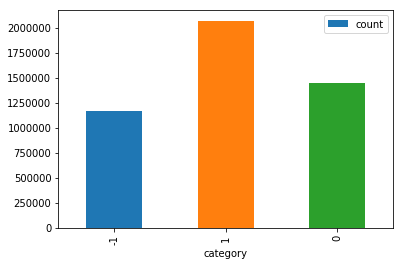

In [19]:
g1.plot.bar(x='category', y='count')

## 3. Build NLP Pipeline

In [20]:
from pyspark.ml.feature import Normalizer, Tokenizer, RegexTokenizer, StopWordsRemover, HashingTF, IDF, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml import Pipeline

### 3.1 Pipeline

In [21]:
tokenizer = RegexTokenizer(inputCol="clean_comment", outputCol="token")
remover = StopWordsRemover(inputCol="token", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="tf", numFeatures=10000)
idf = IDF(inputCol="tf", outputCol="features", minDocFreq=20)
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

In [22]:
pipeline = Pipeline(
    stages=[tokenizer,
            remover,
            hashingTF,
            idf,
            label_stringIdx])

In [23]:
pipelineFit = pipeline.fit(df)
dataset = pipelineFit.transform(df)
dataset.show(5)

+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+-----+
|                body|       clean_comment|category|               token|            filtered|                  tf|            features|label|
+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+-----+
|gg this one's ove...|this one over off...|       0|[this, one, over,...|[one, watch, nfl,...|(10000,[1285,2044...|(10000,[1285,2044...|  1.0|
|No one has a Euro...|one has european ...|       0|[one, has, europe...|[one, european, a...|(10000,[1067,1500...|(10000,[1067,1500...|  1.0|
|That the kid "..r...|that the kid remi...|      -1|[that, the, kid, ...|[kid, reminds, ke...|(10000,[1740,6519...|(10000,[1740,6519...|  2.0|
|Get back to your ...|get back your pot...|       0|[get, back, your,...|[get, back, pott,...|(10000,[1402,1959...|(10000,[1402,1959...|  1.0|

### 3.2 Split Training & Testing Dataset

In [24]:
dataset= dataset.na.drop()

In [25]:
df_train, df_test = dataset.randomSplit([.8,.2],seed=2021)

In [26]:
df_train.select('features','label').show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(10000,[2474,2626...|  2.0|
|(10000,[1150,1770...|  1.0|
|(10000,[1,270,337...|  0.0|
|(10000,[560,909,1...|  2.0|
|(10000,[163,300,5...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [27]:
df_test.select('features','label').show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(10000,[1364,3767...|  1.0|
|(10000,[698,909,1...|  2.0|
|(10000,[422,840,3...|  0.0|
|(10000,[1011,3356...|  0.0|
|(10000,[1955,3145...|  1.0|
+--------------------+-----+
only showing top 5 rows



### 3.3 Balance Training Dataset

In [28]:
df_train.groupby("label").count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|1656507|
|  1.0|1160767|
|  2.0| 933099|
+-----+-------+



In [64]:
df0 = df_train.filter(df_train.label == 0.0)
df1 = df_train.filter(df_train.label == 1.0)
df2 = df_train.filter(df_train.label == 2.0)

In [65]:
df0 = df0.sample(fraction=10/16, seed=2020)
#df2 = df2.sample(fraction=1/4, seed=2020)

In [66]:
df_train_balanced = df0.union(df1)
df_train_balanced = df_train_balanced.union(df2)

In [67]:
df_train_balanced.groupby("label").count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|1035074|
|  1.0|1160767|
|  2.0| 933099|
+-----+-------+



In [68]:
df_test.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|414082|
|  1.0|289240|
|  2.0|233046|
+-----+------+



## 4. Train the Model

In [29]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### 4.1 Logistic Regression

In [30]:
lr = LogisticRegression(featuresCol = 'features', labelCol='label')

lrModel = lr.fit(df_train)
lrPredictions = lrModel.transform(df_test)

In [31]:
lrPredictions.select("label", "features", "prediction").show(10)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  1.0|(10000,[1364,3767...|       0.0|
|  2.0|(10000,[698,909,1...|       2.0|
|  0.0|(10000,[422,840,3...|       0.0|
|  0.0|(10000,[1011,3356...|       0.0|
|  1.0|(10000,[1955,3145...|       1.0|
|  0.0|(10000,[1076,1564...|       1.0|
|  2.0|(10000,[263,625,2...|       0.0|
|  1.0|(10000,[1800,7704...|       1.0|
|  1.0|(10000,[263,616,7...|       1.0|
|  2.0|(10000,[8051,9518...|       1.0|
+-----+--------------------+----------+
only showing top 10 rows



In [32]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print(evaluator.evaluate(lrPredictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(lrPredictions, {evaluator.metricName: "f1"}))

0.8553880525605317
0.854478520467908


In [33]:
lrcol_accu = []
lrcol_f1 = []

for tag in [0.0, 1.0, 2.0]:
    accu = (evaluator.evaluate(lrPredictions.where(col('label')==tag), {evaluator.metricName: "accuracy"}))
    f1 = (evaluator.evaluate(lrPredictions.where(col('label')==tag), {evaluator.metricName: "f1"}))
    
    print(tag, accu, f1)
    lrcol_accu.append(accu)
    lrcol_f1.append(f1)

In [34]:
lr_res = pd.DataFrame({
    'Label': [0.0, 1.0, 2.0],
    'Category': ['positive','neutral','negative'],
    'F1Score': lrcol_f1,
    'Accuracy Score': lrcol_accu
})
lr_res

,Label,Category,F1Score,Accuracy Score
0,0.0,positive,0.930658,0.870308
1,1.0,neutral,0.954108,0.912242
2,2.0,negative,0.862547,0.758314


#### Evaluation -- Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = lrPredictions.select("label")
y_true = y_true.toPandas()

y_pred = lrPredictions.select("prediction")
y_pred = y_pred.toPandas()

In [40]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[2.0,1.0,0.0])
cnf_matrix

array([[176722,  19239,  37085],
       [  9784, 263857,  15599],
       [ 28779,  24924, 360379]])

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[176722  19239  37085]
 [  9784 263857  15599]
 [ 28779  24924 360379]]


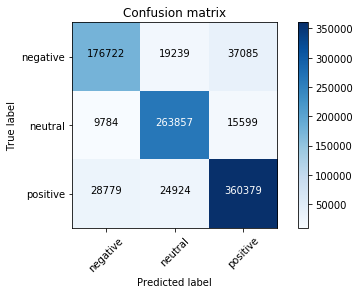

In [58]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['negative','neutral','positive'])
plt.show()

Normalized confusion matrix
[[0.75831381 0.08255452 0.15913167]
 [0.03382658 0.91224243 0.05393099]
 [0.06950073 0.06019098 0.8703083 ]]


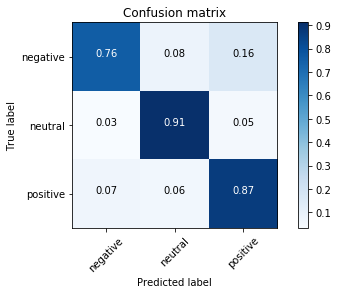

In [59]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes = ['negative','neutral','positive'])
plt.show()

### With Balanced Training Dataset 

In [69]:
lr2 = LogisticRegression(featuresCol = 'features', labelCol='label')

lrModel2 = lr2.fit(df_train_balanced)
lrPredictions2 = lrModel2.transform(df_test)

In [70]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print(evaluator.evaluate(lrPredictions2, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(lrPredictions2, {evaluator.metricName: "f1"}))

0.8502746783315961
0.8502152669632522


### 4.2 Random Forest

In [53]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features") #weightCol='weight'

rfModel = rf.fit(df_train)
rfPredictions = rfModel.transform(df_test)

In [54]:
rfPredictions.select("label", "features", "prediction").show(10)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  1.0|(10000,[1364,3767...|       0.0|
|  2.0|(10000,[698,909,1...|       0.0|
|  0.0|(10000,[422,840,3...|       0.0|
|  0.0|(10000,[1011,3356...|       0.0|
|  1.0|(10000,[1955,3145...|       0.0|
|  0.0|(10000,[1076,1564...|       0.0|
|  2.0|(10000,[263,625,2...|       0.0|
|  1.0|(10000,[1800,7704...|       0.0|
|  1.0|(10000,[263,616,7...|       0.0|
|  2.0|(10000,[8051,9518...|       0.0|
+-----+--------------------+----------+
only showing top 10 rows



In [55]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print(evaluator.evaluate(rfPredictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rfPredictions, {evaluator.metricName: "f1"}))

0.4426913350306717
0.2722375932420075


In [56]:
rfcol_accu = []
rfcol_f1 = []

for tag in [0.0, 1.0, 2.0]:
    accu = (evaluator.evaluate(rfPredictions.where(col('label')==tag), {evaluator.metricName: "accuracy"}))
    f1 = (evaluator.evaluate(rfPredictions.where(col('label')==tag), {evaluator.metricName: "f1"}))
    
    print(tag, accu, f1)
    rfcol_accu.append(accu)
    rfcol_f1.append(f1)

0.0 0.999975850193923 0.9999879249511565
1.0 0.0 0.0
2.0 0.0019309492546535877 0.00385445575084798


In [57]:
rf_res = pd.DataFrame({
    'Label': [0.0, 1.0, 2.0],
    'Category': ['positive','neutral','negative'],
    'F1Score': rfcol_f1,
    'Accuracy Score': rfcol_accu
})
rf_res

,Label,Category,F1Score,Accuracy Score
0,0.0,positive,0.999988,0.999976
1,1.0,neutral,0.000000,0.000000
2,2.0,negative,0.003854,0.001931


#### Evaluatioin - Confusion Matrix

In [60]:
y_true_rf = rfPredictions.select("label")
y_true_rf = y_true_rf.toPandas()

y_pred_rf = rfPredictions.select("prediction")
y_pred_rf = y_pred_rf.toPandas()

In [61]:
cnf_matrix_rf = confusion_matrix(y_true_rf, y_pred_rf,labels=[2.0,1.0,0.0])
cnf_matrix_rf

array([[   450,      0, 232596],
       [     0,      0, 289240],
       [    10,      0, 414072]])

Confusion matrix, without normalization
[[   450      0 232596]
 [     0      0 289240]
 [    10      0 414072]]


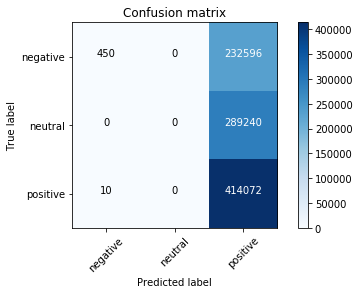

In [62]:
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes = ['negative','neutral','positive'])
plt.show()

Normalized confusion matrix
[[1.93094925e-03 0.00000000e+00 9.98069051e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [2.41498061e-05 0.00000000e+00 9.99975850e-01]]


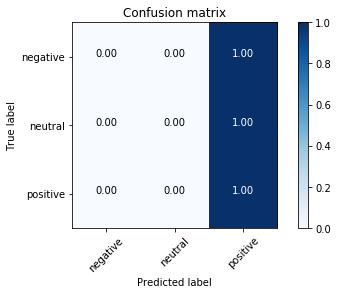

In [63]:
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, normalize=True, classes = ['negative','neutral','positive'])
plt.show()